In [12]:
import pandas as pd

from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
rec_df = pd.read_csv('rec-with-percentage-1.csv')
rec_df = rec_df.sample(frac=1).reset_index(drop=True)
print(rec_df.shape)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(rec_df[['user_id', 'reading_id', 'relative_difficulty']], reader)

algos = [
    SVD(), SVDpp(), NMF(), SlopeOne(), CoClustering(), 
    KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), NormalPredictor(), BaselineOnly()
]

for algo in algos:
    # We can now use this dataset as we please, e.g. calling cross_validate
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
def draw_graph(predictions):
    preds = []
    for i in range(0, len(predictions)):
        preds.append([predictions[i].r_ui, predictions[i].uid, predictions[i].iid, predictions[i].est])
    df = pd.DataFrame(preds)
    plt.scatter(df.iloc[:,1], df.iloc[:,0])
    plt.scatter(df.iloc[:,1], df.iloc[:,3], c='red')
    plt.xlabel('user id')
    plt.ylabel('relative difficulty')
    plt.show()

### percentage of interval ex: 10%

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0155
FCP:  0.6227
5 percent interval: 18.97%
10 percent interval: 43.33%
[Prediction(uid=202, iid=0, r_ui=0.0, est=8.1647661494654855e-05, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=121, iid=1, r_ui=0.0, est=0.014651124448998631, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=94, iid=4, r_ui=0.033175355450236976, est=0.017761425815115084, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=176, iid=2, r_ui=0.02127659574468077, est=0.007787549536274474, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=176, iid=6, r_ui=0.024271844660194164, est=0.011735373004261085, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=58, iid=0, r_ui=0.02499999999999991, est=0.025165296698752115, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=40, iid=2, r_ui=0.014184397163120588, est=0.037579918374683885, details={'

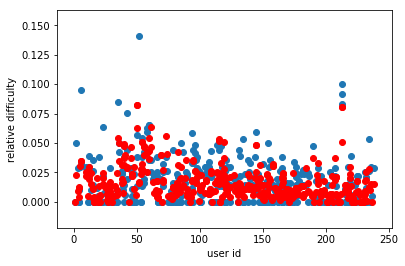

In [33]:
def percentCorrect(prediction, ground_truth, bound_percent):
    in_bound = 0
    total_non_zero = 0
    for index, x in enumerate(prediction):
        if ground_truth[index] != 0:
            if (x <= ground_truth[index] * (1 + bound_percent) and x >= ground_truth[index] * (1 - bound_percent)):
                in_bound += 1
            total_non_zero += 1
    return in_bound/total_non_zero

rec_df = pd.read_csv('rec-with-percentage-no-dup.csv')
rec_df = rec_df.sample(frac=1).reset_index(drop=True)

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(rec_df[['user_id', 'reading_id', 'relative_difficulty']], reader)

algos = [
#     SVD(),
#     SVDpp(), 
#     KNNBasic(), 
#     KNNWithMeans(), 
    KNNWithZScore(), 
#     KNNBaseline(), 
#     NormalPredictor(), 
#     BaselineOnly(),
#     SlopeOne()
    #     CoClustering(), #predict all 0, the RMSE is 0.0252
    #     NMF(), #predicts 0 most of the times
]

algo_names = [
#     'SVD',
#     'SVDpp', 
#     'KNNBasic', 
#     'KNNWithMeans', 
    'KNNWithZScore'
#     'KNNBaseline', 
#     'NormalPredictor', 
#     'BaselineOnly',
#     'SlopeOne'
    #     CoClustering(), #predict all 0, the RMSE is 0.0252
    #     NMF(), #predicts 0 most of the times
]

measures = []
for index, algo in enumerate(algos):
    trainset, testset = train_test_split(data, test_size=.25)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    fcp = accuracy.fcp(predictions)
    truth = []
    preds = []
    truth_count = []
    preds_count = []
    for i in range(0, len(predictions)):
        row = rec_df.loc[(rec_df['user_id'] == predictions[i].uid) & (rec_df['reading_id'] == predictions[i].iid)]
        preds_count.append(row.iloc[0]['unique_word_count'] * predictions[i].est)
        truth_count.append(row.iloc[0]['unknown_count'])
        truth.append(predictions[i].r_ui)
        preds.append(predictions[i].est)
    r2 = r2_score(preds, truth)
    interval5 = "{0:.2f}%".format(percentCorrect(truth_count, preds_count, 0.3) * 100)
    interval10 = "{0:.2f}%".format(percentCorrect(truth_count, preds_count, 0.7) * 100)
    print('5 percent interval: ' + str(interval5))
    print('10 percent interval: ' + str(interval10))
    print(predictions)
#     print('coefficient of determination: ' + str(r2))
    draw_graph(predictions)
    measures.append([algo_names[index], rmse, fcp, interval5, interval10])

### Reading-wise => Relative Difficulty

In [ ]:
def percentCorrect(prediction, ground_truth, bound):
    in_bound = 0
    for index, x in enumerate(prediction):
        if (x <= ground_truth[index] + bound and x >= ground_truth[index] - bound):
            in_bound = in_bound + 1
    return in_bound/len(prediction)

rec_df = pd.read_csv('rec-with-percentage-no-dup.csv')
rec_df = rec_df.sample(frac=1).reset_index(drop=True)

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(rec_df[['user_id', 'reading_id', 'relative_difficulty']], reader)

algos = [
    SVD(),
    SVDpp(), 
    KNNBasic(), 
    KNNWithMeans(), 
    KNNWithZScore(), 
    KNNBaseline(), 
    NormalPredictor(), 
    BaselineOnly(),
    SlopeOne()
    #     CoClustering(), #predict all 0, the RMSE is 0.0252
    #     NMF(), #predicts 0 most of the times
]

algo_names = [
    'SVD',
    'SVDpp', 
    'KNNBasic', 
    'KNNWithMeans', 
    'KNNWithZScore', 
    'KNNBaseline', 
    'NormalPredictor', 
    'BaselineOnly',
    'SlopeOne'
    #     CoClustering(), #predict all 0, the RMSE is 0.0252
    #     NMF(), #predicts 0 most of the times
]

measures = []
for index, algo in enumerate(algos):
    trainset, testset = train_test_split(data, test_size=.25)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    fcp = accuracy.fcp(predictions)
    truth = []
    preds = []
    truth_count = []
    preds_count = []
    for i in range(0, len(predictions)):
        row = rec_df.loc[(rec_df['user_id'] == predictions[i].uid) & (rec_df['reading_id'] == predictions[i].iid)]
        preds_count.append(row.iloc[0]['unique_word_count'] * predictions[i].est)
        truth_count.append(row.iloc[0]['unknown_count'])
        truth.append(predictions[i].r_ui)
        preds.append(predictions[i].est)
    r2 = r2_score(preds, truth)
    interval = "{0:.2f}%".format(percentCorrect(truth_count, preds_count, 2) * 100)
    interval25 = "{0:.2f}%".format(percentCorrect(truth_count, preds_count, 2.5) * 100)
    print('percent interval: ' + str(interval))
#     print('coefficient of determination: ' + str(r2))
    draw_graph(predictions)
    measures.append([algo_names[index], rmse, fcp, interval, interval25])

In [ ]:
from tabulate import tabulate
df = pd.DataFrame(measures, columns=['algo name', 'rmse', 'fcp', 'interval +/- 2', 'interval +/- 2.5'])
df = df.sort_values('rmse', ascending=False).reset_index(drop=True)
print(tabulate(df[['algo name', 'rmse', 'fcp']], headers='keys', tablefmt='psql'))
df = df.sort_values('interval +/- 2', ascending=True).reset_index(drop=True)
print(tabulate(df[['algo name', 'interval +/- 2', 'interval +/- 2.5']], headers='keys', tablefmt='psql'))

### Reading-wise => Unknown Count

In [ ]:
def percentCorrect(prediction, ground_truth, bound):
    in_bound = 0
    for index, x in enumerate(prediction):
        if (x <= ground_truth[index] + bound and x >= ground_truth[index] - bound):
            in_bound = in_bound + 1
    return in_bound/len(prediction)

rec_df = pd.read_csv('rec-with-percentage-no-dup.csv')
rec_df = rec_df.sample(frac=1).reset_index(drop=True)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(rec_df[['user_id', 'reading_id', 'unknown_count']], reader)

algos = [
    SVD(),
    SVDpp(), 
#     NMF(), #predicts 0 most of the times
    KNNBasic(), 
    KNNWithMeans(), 
    KNNWithZScore(), 
    KNNBaseline(), 
    NormalPredictor(), 
    BaselineOnly(),
#     CoClustering(), #predict all 0, the RMSE is 0.0252
    SlopeOne()
]

for algo in algos:
    # We can now use this dataset as we please, e.g. calling cross_validate
    trainset, testset = train_test_split(data, test_size=.25)
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions)
    accuracy.fcp(predictions)
    truth = []
    preds = []
    truth_count = []
    preds_count = []
    for i in range(0, len(predictions)):
#         print(predictions[i].r_ui, predictions[i].est)
        row = rec_df.loc[(rec_df['user_id'] == predictions[i].uid) & (rec_df['reading_id'] == predictions[i].iid)]
        preds_count.append(row.iloc[0]['unique_word_count'] * predictions[i].est)
        truth_count.append(row.iloc[0]['unknown_count'])
        truth.append(predictions[i].r_ui)
        preds.append(predictions[i].est)
    r2 = r2_score(preds, truth)
    interval = percentCorrect(truth, preds, 2)
    print('percent interval: ' + str(interval))
#     print('coefficient of determination: ' + str(r2))

In [ ]:
rec_df = pd.read_csv('rec-with-percentage-no-dup.csv')
rec_df.sort_values(by=['user_id'])
rec_df.head()

In [ ]:
predictions = {
    1: [],  # leave 1 out
    2: [],  # leave 2 out
    3: [],
    4: [],
    5: [],
    6: []
}

truths = {
    1: [],  # leave 1 out
    2: [],  # leave 2 out
    3: [],
    4: [],
    5: [],
    6: []
}


def predict(r_id, u_id):
    algo = KNNBasic()
    train_df = rec_df[(rec_df.reading_id > r_id) | (rec_df.user_id != u_id)]
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(train_df[['user_id', 'reading_id', 'relative_difficulty']], reader)
    train_set = data.build_full_trainset()
    algo.fit(train_set)
    for i in range(r_id + 1, 7):
        r_ui=rec_df[(rec_df.reading_id == i) & (rec_df.user_id == u_id)]
        pred = algo.predict(u_id, i, r_ui=r_ui.relative_difficulty.item(), clip=False)
        predictions[i].append(pred.est)
        truths[i].append(pred.r_ui)

max_user_id = rec_df.user_id.max()
print(max_user_id)
for r_id in range(7):
    for u_id in range(max_user_id):
        predict(r_id, u_id)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    return sqrt(mean_squared_error(prediction, ground_truth))
for i in range(1, 7):
    print(len(predictions[i]))
    print('RMSE for leave ' + str(i) + ' out: ', rmse(predictions[i], truths[i]))

In [ ]:
df = pd.DataFrame([0.0162, 0.0164, 0.0197, 0.0218, 0.0235, 0.0212], columns=['RMSE'])
df.index = ['Leave ' + str(i) + ' out' for i in range(1, 7)]
print(tabulate(df, headers='keys', tablefmt='psql'))

In [ ]:
df = pd.DataFrame({
    1: 0,
    2: 0.028369,
    3: 0.011834,
    4: 0.066351,
    5: 0.024391,
    6: 0.030492,
    7: -1
},index=[0])
print(tabulate(df, headers='keys', tablefmt='psql'))

In [ ]:
# from collections import defaultdict
# user_ratings = defaultdict(list)
# for uid, iid, r_ui, _ in data.raw_ratings:
#     user_ratings[uid].append((uid, iid, r_ui, None))
from sklearn.model_selection import LeavePOut
import numpy as np
X = np.ones(4)
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):
     print("%s %s" % (train, test))